In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow keras pillow numpy tqdm

     |████████████████████████████████| 462 kB 15.6 MB/s 


In [4]:
import string
import numpy as np
import PIL
from pathlib import Path
import io
import requests
from PIL import Image as pil_image
import os
from pickle import dump, load
from torch.utils.data import Dataset
from statistics import mean
from keras.preprocessing.image import ImageDataGenerator


from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
# from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [5]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [6]:
# Set these path according to project folder in you system
dataset_text ="/content/drive/MyDrive/CSE_465_Image_Caption_Project/Downloads/Flickr8k_text"
dataset_images = "/content/drive/MyDrive/CSE_465_Image_Caption_Project/Downloads/Flicker8k_Dataset"

#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" , len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "/content/drive/MyDrive/CSE_465_Image_Caption_Project/Downloads/descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [7]:



def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            
            image = Image.open(filename)    

            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("/content/drive/MyDrive/CSE_465_Image_Caption_Project/Downloads/features.p","wb"))

83697664/83683744 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/16182 [00:00<?, ?it/s]

NameError: ignored

In [12]:
features = load(open("/content/drive/MyDrive/CSE_465_Image_Caption_Project/Downloads/features.p","rb"))

# Loading Dataset For Training The Dodel

In [8]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<Image Caption Starting:> ' + " ".join(image_caption) + ' <:Image Caption Ending>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("/content/drive/MyDrive/CSE_465_Image_Caption_Project/Downloads/features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("/content/drive/MyDrive/CSE_465_Image_Caption_Project/Downloads/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [9]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('/content/drive/MyDrive/CSE_465_Image_Caption_Project/Downloads/tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7579

In [10]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [13]:
#create input-output sequence pairs from the image description.


#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((67, 2048), (67, 32), (67, 7579))

# Defining the CNN-LSTM model





In [14]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='/content/drive/MyDrive/CSE_465_Image_Caption_Project/Downloads/model_CNN-LSTM.png', show_shapes=True)

    return model

In [15]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image

In [16]:
IMAGE_SIZE = [224, 224]
vgg = VGG19(input_shape = IMAGE_SIZE + [3], weights='imagenet',include_top=False) 

80150528/80134624 [==============================] - 1s 0us/step


In [17]:
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

In [18]:
# train the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
	# fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('model_' + str(i) + '.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1940224     ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_3[0][0]']                
                                                                                              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


InvalidArgumentError: ignored

# VGG-16


In [19]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [ ]:
#IMAGE_SIZE = [224, 224]
#vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet',include_top=False) 

58900480/58889256 [==============================] - 0s 0us/step


# Defining the VGG16 AND Resnet50 model

In [31]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#checkpoint = ModelCheckpoint("model_4.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=10,generator = data_generator(train_descriptions, train_features, tokenizer, max_length), validation_steps=10,epochs=10)  #callbacks=[checkpoint,early]

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


InvalidArgumentError: ignored

In [32]:
ax[0].plot(model.hist.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.hist.history['Epoch'],color='r',label='Epoch')

NameError: ignored

In [33]:
import matplotlib.pyplot as plt
#plt.plot(hist.history["acc"])
#plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
#plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

NameError: ignored

In [24]:
import matplotlib.pyplot as plt

In [25]:

 
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['Epoch'], label='Epoch')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
# train the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
	# fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('model_' + str(i) + '.h5')

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 32, 256)      1940224     ['input_24[0][0]']               
                                                                                                  
 dropout_20 (Dropout)           (None, 2048)         0           ['input_23[0][0]']               
                                                                                           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


 163/6000 [..............................] - ETA: 10:00 - loss: 5.1537

KeyboardInterrupt: ignored


# TRAINING SECTION

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
print(model,'model')
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("/content/drive/MyDrive/CSE_465_Image_Caption_Project/Downloads/modelN") 
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save("/content/drive/MyDrive/CSE_465_Image_Caption_Project/Downloads/model_FOR" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7579
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1940224     ['input_7[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_6[0][0]']    

FileExistsError: ignored

In [ ]:
callbacks_list = [PlotLearning()]

model.fit(features,
          model2_RESNET50-VGG16.png,
          epochs =10,
          batch_size = batch_size,
          validation_data=(x_test, y_test),
          verbose=1,
          shuffle=True,
          class_weight=class_weight,
          callbacks=callbacks_list
          )

NameError: ignored

In [1]:

#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

NameError: ignored

# TEST THE MODEL USING DUMY FOLLOWING IMAGE AND CODE

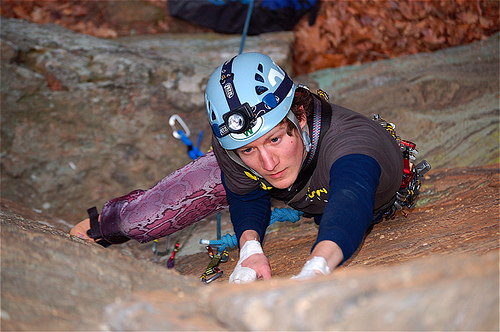

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/CSE-465/Flicker8k_Dataset/111537222_07e56d5a30.jpg')
img

In [ ]:
!python3 '/content/drive/MyDrive/CSE-465/testing_caption_generator.py' -i '/content/drive/MyDrive/CSE-465/Flicker8k_Dataset/111537222_07e56d5a30.jpg'
# !python3 '/content/drive/MyDrive/ML/testing_caption_generator.py' -i '/content/drive/MyDrive/ML/Flicker8k_Dataset/3738685861_8dfff28760.jpg'

2022-04-17 17:47:38.611675: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-04-17 17:47:45.329493: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.



start man is climbing up rock end


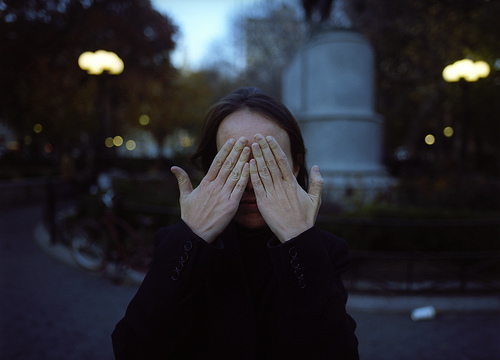

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/CSE-465/Flicker8k_Dataset/3275704430_a75828048f.jpg')
img

In [ ]:
!python3 '/content/drive/MyDrive/CSE-465/testing_caption_generator.py' -i '/content/drive/MyDrive/CSE-465/Flicker8k_Dataset/3275704430_a75828048f.jpg'
# !python3 '/content/drive/MyDrive/ML/testing_caption_generator.py' -i '/content/drive/MyDrive/ML/Flicker8k_Dataset/3738685861_8dfff28760.jpg'

2022-04-17 18:20:41.547727: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-04-17 18:20:46.616605: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.



start man in black shirt and black hat is sitting on the sidewalk end
